In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
os.environ['CLMM_MODELING_BACKEND'] = 'ccl'
import clmm
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as utils
import astropy.units as u
from clmm import Cosmology
from clmm.support import mock_data as mock
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
import numpy as np
import pyccl as ccl
import numpy as np
import sys
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from scipy.integrate import quad,simps, dblquad
%load_ext autoreload

%autoreload 2
from astropy.io import fits as fits
from cluster_toolkit import miscentering
from cluster_toolkit import deltasigma
sys.path.append('../modeling')
import CL_COUNT_modeling_completeness as comp
import CL_COUNT_modeling_purity as pur
import CL_COUNT_modeling_halo_mass_function as hmf
import CL_COUNT_modeling_richness_mass_relation as rm_relation
import CL_MASS_cluster_mass as cl_mass
import CL_COUNT_cluster_abundance as cl_count
import CL_COUNT_class_likelihood as likelihood
import CL_LENSING_cluster_lensing as cl_lensing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Miscentering in data

In [2]:
name = '../data/matched_pairs_Mfofcut.fits'
dat = fits.open(name)
dat_open= dat[1].data

In [3]:
#from CLMM
def _compute_lensing_angles_astropy(ra_lens, dec_lens, ra_source_list, dec_source_list):
    r"""Compute the angular separation between the lens and the source and the azimuthal
    angle from the lens to the source in radians.

    Parameters
    ----------
    ra_lens: float
        Right ascension of the lensing cluster in degrees
    dec_lens: float
        Declination of the lensing cluster in degrees
    ra_source_list: array
        Right ascensions of each source galaxy in degrees
    dec_source_list: array
        Declinations of each source galaxy in degrees

    Returns
    -------
    angsep: array
        Angular separation between the lens and the source in radians
    phi: array
        Azimuthal angle from the lens to the source in radians
    """
    sk_lens = SkyCoord(ra_lens * u.deg, dec_lens * u.deg, frame="icrs")
    sk_src = SkyCoord(ra_source_list * u.deg, dec_source_list * u.deg, frame="icrs")
    angsep, phi = sk_lens.separation(sk_src).rad, sk_lens.position_angle(sk_src).rad
    # Transformations for phi to have same orientation as _compute_lensing_angles_flatsky
    phi += 0.5 * np.pi
    if np.iterable(phi):
        phi[phi > np.pi] -= 2 * np.pi
        phi[angsep == 0] = 0
    else:
        phi -= 2 * np.pi if phi > np.pi else 0
        phi = 0 if angsep == 0 else phi
    return angsep, phi

In [4]:
angsep, phi = _compute_lensing_angles_astropy(dat_open['cat1_ra'] , dat_open['cat1_dec'], dat_open['cat2_ra'], dat_open['cat2_dec'])

In [5]:
theta = angsep
Da = cosmo.eval_da_z1z2(0, dat_open['cat2_z'])
Rproj = theta*Da

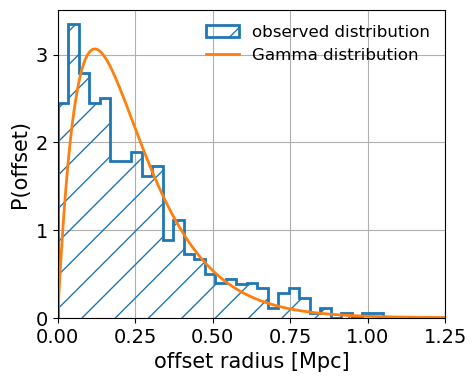

In [6]:
plt.figure(figsize=(5,4))
bins=np.linspace(1e-9, 2, 60)
R_prof_cat = Rproj[(dat_open['cat2_z'] > 0.2)*(dat_open['cat2_z'] < 1)*(dat_open['cat1_richness'] > 20)*(dat_open['cat1_richness'] < 200)]
n,b,s=plt.hist(R_prof_cat, bins=bins, density=True, histtype='step', hatch='/', lw=2, label = 'observed distribution')
x=np.linspace(0,2,1000)
plt.plot(x,cl_lensing.miscentering_distribution(x, .12, which='gamma'),'-', lw=2, label = 'Gamma distribution')
#plt.plot(x,cl_lensing.miscentering_distribution(x, .2, which='raleigh'), '-', lw=2, label = 'Raleigh')
plt.xlim(0, 1.25)

plt.grid(which='both')
plt.legend(fontsize = 12, frameon = False, loc = 'upper right')
plt.xlabel(r'offset radius [Mpc]', fontsize = 15)
plt.ylabel(r'P(offset)', fontsize = 15)
plt.tick_params(axis='both', which = 'major', labelsize= 14)
#plt.show()
plt.savefig(f'../fig/offset_distribution_cosmoDC2_redmapper.png', dpi = 300,bbox_inches='tight',)

In [7]:
R_cut = Rproj[(dat_open['cat2_z'] > 0.2)*(dat_open['cat2_z'] < 1)*(dat_open['cat1_richness'] > 20)*(dat_open['cat1_richness'] < 200)]

In [8]:
print(np.sum((R_cut==0)/len(R_cut)))

0.855187517109225


In [9]:
print(np.sum(R_cut!=0)/len(R_cut))

0.1448124828907747


In [10]:
import cluster_toolkit as ct

In [11]:
logm = 14.5
cluster_m = 10**logm
cluster_z = 0.5
moo = clmm.Modeling(massdef = 'critical', delta_mdef = 200, halo_profile_model = 'nfw')
mock_cosmo = Cosmology(H0=70.0, Omega_dm0=0.27-0.045, Omega_b0=0.045, Omega_k0=0.0)
cosmo_ccl = ccl.Cosmology(Omega_c=0.27-0.045, Omega_b=0.045, h=0.7, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)
deff = ccl.halos.massdef.MassDef(200, 'critical')
conc = ccl.halos.concentration.ConcentrationDuffy08(mass_def=deff)
concentration = conc._concentration(cosmo_ccl, 10**logm, 1/(1 + cluster_z))
moo.set_cosmo(mock_cosmo)
moo.set_mass(cluster_m) 
moo.set_concentration(concentration)

In [12]:
print('concentration = ' + str(concentration))

concentration = 3.1781288504006686


### Compute Miscentering

In [13]:
R_real = np.logspace(np.log10(.01), np.log10(100), 100)

In [14]:
R_Sigma = np.logspace(np.log10(0.0001), np.log10(101), 500)
Sigma_nfw_clmm = moo.eval_surface_density(R_Sigma, cluster_z)
Rmis = 0.2
ds_mis_rayleigh, s_mis_rayleigh =  cl_lensing.predict_sigma_excess_miscentering_single(Sigma_nfw_clmm, R_real, R_Sigma, Rmis, cluster_z, "rayleigh", cosmo)
ds_mis_gamma, s_mis_gamma =  cl_lensing.predict_sigma_excess_miscentering_single(Sigma_nfw_clmm, R_real, R_Sigma, Rmis, cluster_z, "gamma", cosmo)

### Computing Power spectrum for 2h term

In [15]:
ds_unbaised = moo.eval_excess_surface_density_2h(R_real, cluster_z)

In [16]:
from cluster_toolkit import boostfactors
import numpy as np
#R = R/0.71 #Mpc/h comoving
B0 = 0.1 #Typical value
Rs = 0.1/0.71 #Mpc/h comoving; typical value
alpha = -1.0 #arbitrary
B = boostfactors.boost_powerlaw_at_R(0.71*R_real, B0, 0.71*Rs, alpha)

0.855187517109225


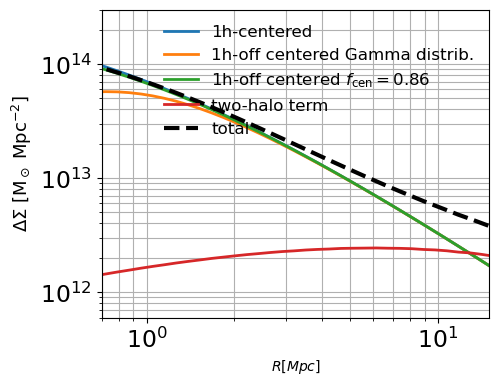

In [17]:
dL = cosmo.eval_da(cluster_z)
plt.figure(figsize = (5,4))
#1h cen
ds_baseline=moo.eval_excess_surface_density(R_real,cluster_z)
#plt.loglog(R,ds_baseline, ls='-' , c = 'C0',label = r'$\Delta\Sigma_{nfw}^{\rm cen}$')
f_cen = np.sum((R_cut==0)/len(R_cut))
print(f_cen)
ds2h = 6 * ds_unbaised
dsmis = (1-f_cen)*np.interp(R_real, R_real, ds_mis_gamma) + f_cen*ds_baseline
ds_tot = (dsmis + ds2h)
plt.plot(R_real, ds_baseline,'-',linewidth=2,label = r'1h-centered')
plt.plot(R_real, ds_mis_gamma,'-',linewidth=2,label = r'1h-off centered Gamma distrib.')
plt.plot(R_real, dsmis,'-',linewidth=2,label = r'1h-off centered '+r'$f_{\rm cen}=$'+f'{f_cen:.2f}')
plt.plot(R_real, ds2h,'-',linewidth=2,label = r'two-halo term')
plt.loglog(R_real, ds_tot,'--k',linewidth=3,label = r'total')
#plt.loglog(R_real, ds_tot/B,'--',linewidth=2,label = r'total+Boost')
plt.legend(fontsize = 12, frameon = False, loc = 'upper right')
plt.xscale('log')
plt.ylim(6*1e11, 3*1e14)
plt.xlim(0.7, 15)
plt.xlabel(r'$R [Mpc]$', fontsize = 10)
plt.ylabel(r'$\Delta\Sigma$ ' +'$[$' + r'${\rm M}$' + r'$_\odot\;$'+ r'${\rm Mpc}$'+r'$^{-2}$'r'$]$', fontsize = 13)
plt.grid(which='both')
plt.legend(fontsize = 12, frameon = False, loc = 'upper right')
plt.tick_params(axis='both', which = 'major', labelsize= 17)

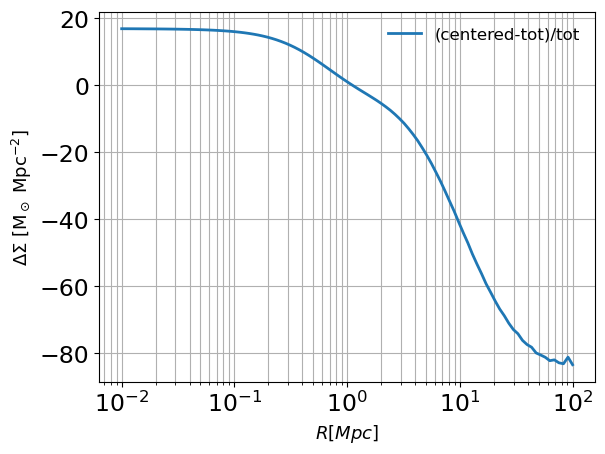

In [18]:
plt.plot(R_real, 100*(ds_baseline-ds_tot)/ds_tot, '-',linewidth=2,label = r'(centered-tot)/tot')
plt.xscale('log')
plt.xlabel(r'$R [Mpc]$', fontsize = 13)
plt.ylabel(r'$\Delta\Sigma$ ' +'$[$' + r'${\rm M}$' + r'$_\odot\;$'+ r'${\rm Mpc}$'+r'$^{-2}$'r'$]$', fontsize = 13)


plt.grid(which='both')
plt.legend(fontsize = 12, frameon = False, loc = 'upper right')
plt.tick_params(axis='both', which = 'major', labelsize= 17)